1.思考在自然语言处理中如何发掘模型的可解释性

2.在Seq2Seq和注意力机制中如何可视化模型细节

3.对抗样本能否运用到自然语言处理模型中

4.复现Kaggle心脏病数据集冠军kernel，理解所用的模型可解释性技巧

写成博客提交即可，markdown和word均可

1.思考在自然语言处理中如何发掘模型的可解释性

模型的可解释性包括对模型输出结果的可解释性、模型输入与输出之间关联的可解释性、模型中间过程逻辑的可解释性。
北大、哈工大和加州大学圣巴巴拉分校在 ACL 2019 的一篇论文中联合提出了一个全新的生成性解释框架，该框架能够对分类策略进行学习，并同时提供细粒度的解释。这项研究还提供了解释因子以及最小化风险训练（minimum risk training）方法，以便进行学习并产生更加合理的解释。
该生成性解释框架在给给文本分类的同时，生成一个解释模型预测结果的细粒度信息。

2.在Seq2Seq和注意力机制中如何可视化模型细节

将encoder生成的context上下文向量映射到word embedding词向量空间，可视化context向量在词向量空间的语言表示。
在注意力机制中一个时间步长的输入：context向量和上一个时间步长的输出隐状态可以通过维度变化映射回word embedding词向量空间，查看对应的语言特征

3.对抗样本能否运用到自然语言处理模型中

将含有噪声干扰的文本样本，比如词向量X对应的噪声X'，共同输入给模型，使得模型能够学习抵御这些噪声干扰，使得最后输出的结果对于有噪声干扰条件下得到与正确输入向量X相同的输出结果

4.复现Kaggle心脏病数据集冠军kernel，理解所用的模型可解释性技巧

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox import pdp, info_plots
np.random.seed(42)
%matplotlib inline

C:\Users\aceryoung\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\aceryoung\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
data = pd.read_csv('./heart-disease-uci/heart.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
data.head(10)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

In [5]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [6]:
data.loc[data['sex'] == 0, 'sex'] = 'female'
data.loc[data['sex'] == 1, 'sex'] = 'male'

data.loc[data['cp'] == 1, 'cp'] = 'typical'
data.loc[data['cp'] == 2, 'cp'] = 'atypical'
data.loc[data['cp'] == 3, 'cp'] = 'no pain'
data.loc[data['cp'] == 4, 'cp'] = 'no feel'

data.loc[data['fbs'] == 1, 'fbs'] = 'higher than 120 mg/dl'
data.loc[data['fbs'] == 0, 'fbs'] = 'lower than 120 mg/dl'

data.loc[data['restecg'] == 0, 'restecg'] = 'normal'
data.loc[data['restecg'] == 1, 'restecg'] = 'ST-wave abnormality'
data.loc[data['restecg'] == 2, 'restecg'] = 'left ventricular hypertorphy'

data.loc[data['exang'] == 1, 'exang'] = 'true'
data.loc[data['exang'] == 0, 'exang'] = 'false'

data.loc[data['slope'] == 1, 'slope'] = 'up'
data.loc[data['slope'] == 2, 'slope'] = 'flat'
data.loc[data['slope'] == 3, 'slope'] = 'down'

data.loc[data['thal'] == 1, 'thal'] = 'normal'
data.loc[data['thal'] == 2, 'thal'] = 'fixed defect'
data.loc[data['thal'] == 3, 'thal'] = 'reversable defect'

In [7]:
data.dtypes

age           int64
sex          object
cp           object
trestbps      int64
chol          int64
fbs          object
restecg      object
thalach       int64
exang        object
oldpeak     float64
slope        object
ca            int64
thal         object
target        int64
dtype: object

In [8]:
data.head(10)

age     sex        cp  trestbps  chol                    fbs  \
0   63    male   no pain       145   233  higher than 120 mg/dl   
1   37    male  atypical       130   250   lower than 120 mg/dl   
2   41  female   typical       130   204   lower than 120 mg/dl   
3   56    male   typical       120   236   lower than 120 mg/dl   
4   57  female         0       120   354   lower than 120 mg/dl   
5   57    male         0       140   192   lower than 120 mg/dl   
6   56  female   typical       140   294   lower than 120 mg/dl   
7   44    male   typical       120   263   lower than 120 mg/dl   
8   52    male  atypical       172   199  higher than 120 mg/dl   
9   57    male  atypical       150   168   lower than 120 mg/dl   

               restecg  thalach  exang  oldpeak slope  ca               thal  \
0               normal      150  false      2.3     0   0             normal   
1  ST-wave abnormality      187  false      3.5     0   0       fixed defect   
2               normal      172  false      1.4  flat   0       fixed defect   
3  ST-wave abnormality      178  false      0.8  flat   0       fixed defect   
4  ST-wave abnormality      163   true      0.6  flat   0       fixed defect   
5  ST-wave abnormality      148  false      0.4    up   0             normal   
6               normal      153  false      1.3    up   0       fixed defect   
7  ST-wave abnormality      173  false      0.0  flat   0  reversable defect   
8  ST-wave abnormality      162  false      0.5  flat   0  reversable defect   
9  ST-wave abnormality      174  false      1.6  flat   0       fixed defect   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1  
6       1  
7       1  
8       1  
9       1

In [9]:
data = pd.get_dummies(data, drop_first = True)  #分类变量变成类似one_hot类型变量，丢掉第一个分类变量

In [10]:
data.head()

age  trestbps  chol  thalach  oldpeak  ca  target  sex_male  cp_atypical  \
0   63       145   233      150      2.3   0       1         1            0   
1   37       130   250      187      3.5   0       1         1            1   
2   41       130   204      172      1.4   0       1         0            0   
3   56       120   236      178      0.8   0       1         1            0   
4   57       120   354      163      0.6   0       1         0            0   

   cp_no pain  cp_typical  fbs_lower than 120 mg/dl  \
0           1           0                         0   
1           0           0                         1   
2           0           1                         1   
3           0           1                         1   
4           0           0                         1   

   restecg_left ventricular hypertorphy  restecg_normal  exang_true  \
0                                     0               1           0   
1                                     0               0           0   
2                                     0               1           0   
3                                     0               0           0   
4                                     0               0           1   

   slope_flat  slope_up  thal_fixed defect  thal_normal  \
0           0         0                  0            1   
1           0         0                  1            0   
2           1         0                  1            0   
3           1         0                  1            0   
4           1         0                  1            0   

   thal_reversable defect  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', 1), data['target'], test_size = 0.2, random_state = 42)

In [12]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]
#y_train[y_train == 0] = 'no disease'
#y_train[y_train == 1] = 'disease'
y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [14]:
import os
os.environ["PATH"]+= os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [15]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

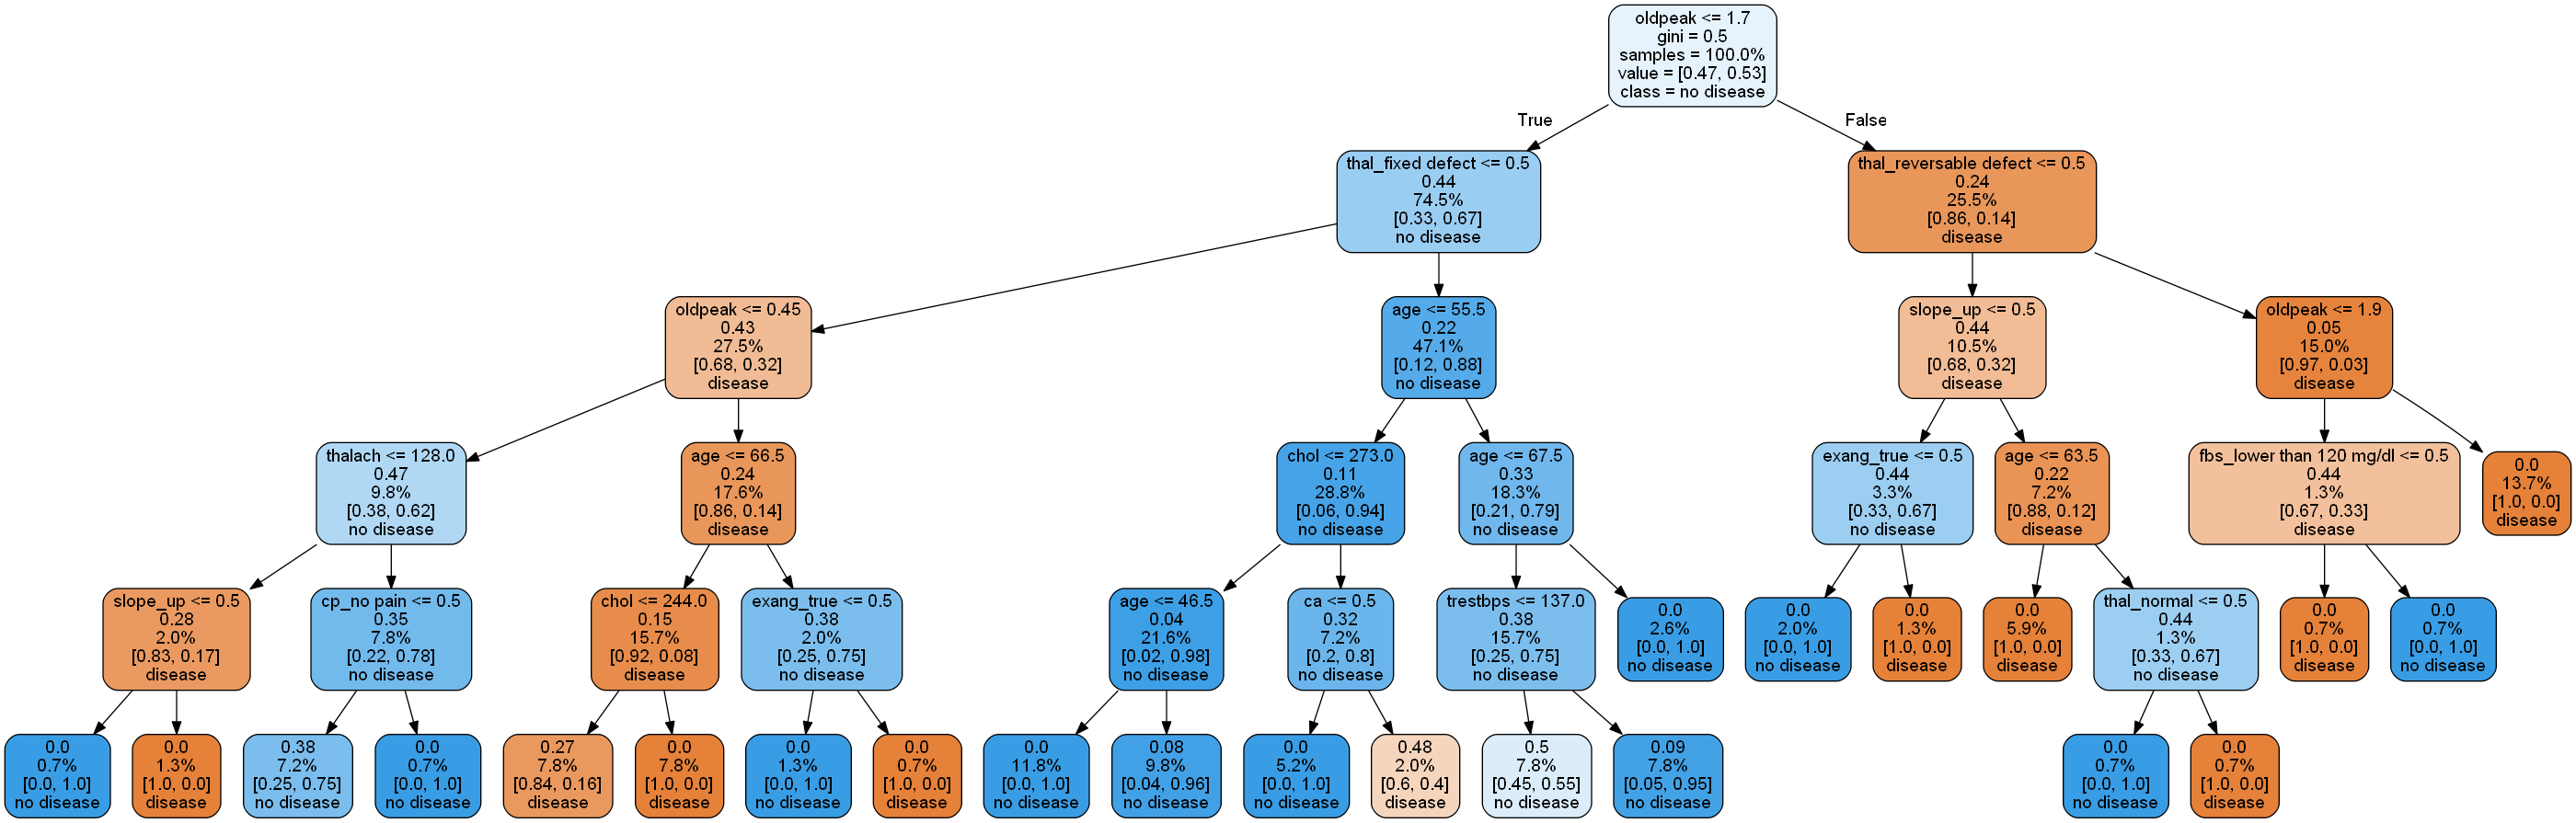

In [16]:
#method 2
import pydotplus
from IPython.display import Image
img = pydotplus.graph_from_dot_file('tree.dot')
Image(img.create_png())

In [18]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [19]:
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[26,  3],
       [ 6, 26]], dtype=int64)

\begin{align} Sensitivity = \frac{True\:Positives}{True\:Positives + False\:Negatives} \end{align}

\begin{align} Specificity = \frac{True\:Negatives}{True\:Negatives + False\:Positives} \end{align}

In [20]:
total = sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,1]/(confusion_matrix[0,1]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.3333333333333333
Specificity :  0.896551724137931


In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
fpr

array([0.        , 0.        , 0.        , 0.03448276, 0.03448276,
       0.06896552, 0.06896552, 0.10344828, 0.10344828, 0.13793103,
       0.13793103, 0.17241379, 0.17241379, 0.20689655, 0.20689655,
       0.65517241, 0.65517241, 1.        ])

In [22]:
tpr

array([0.     , 0.03125, 0.5    , 0.5    , 0.625  , 0.625  , 0.71875,
       0.71875, 0.8125 , 0.8125 , 0.875  , 0.875  , 0.9375 , 0.9375 ,
       0.96875, 0.96875, 1.     , 1.     ])

In [23]:
thresholds

array([1.95881014, 0.95881014, 0.75453737, 0.75246744, 0.6878246 ,
       0.67893044, 0.59711692, 0.59187557, 0.56039753, 0.47625403,
       0.4663815 , 0.46004816, 0.4527039 , 0.32159652, 0.3143933 ,
       0.13396553, 0.1305076 , 0.02299896])

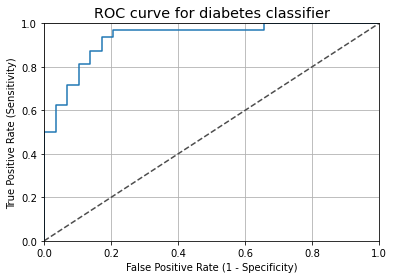

In [24]:
fig, ax = plt.subplots()
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [25]:
auc(fpr, tpr)

0.9331896551724139

In [26]:
perm = PermutationImportance(model, random_state = 3).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

可逆地中海贫血症对模型的影响最大

In [27]:
base_features = data.columns.values.tolist()

In [28]:
base_features

['age',
 'trestbps',
 'chol',
 'thalach',
 'oldpeak',
 'ca',
 'target',
 'sex_male',
 'cp_atypical',
 'cp_no pain',
 'cp_typical',
 'fbs_lower than 120 mg/dl',
 'restecg_left ventricular hypertorphy',
 'restecg_normal',
 'exang_true',
 'slope_flat',
 'slope_up',
 'thal_fixed defect',
 'thal_normal',
 'thal_reversable defect']

In [29]:
base_features.remove('target')

In [30]:
feat_name = 'thal_reversable defect'

In [31]:
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

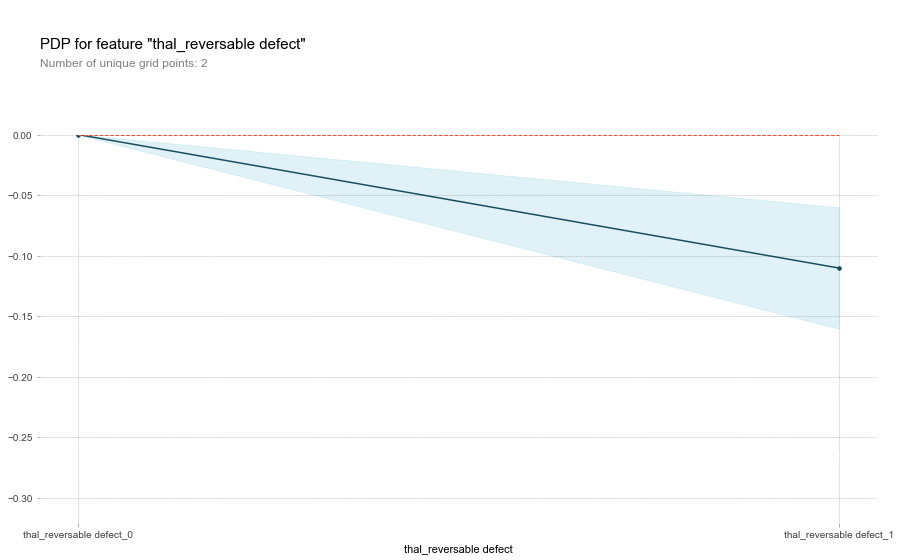

In [32]:
pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

发现有可逆地中海贫血症，得心脏病的概率越低

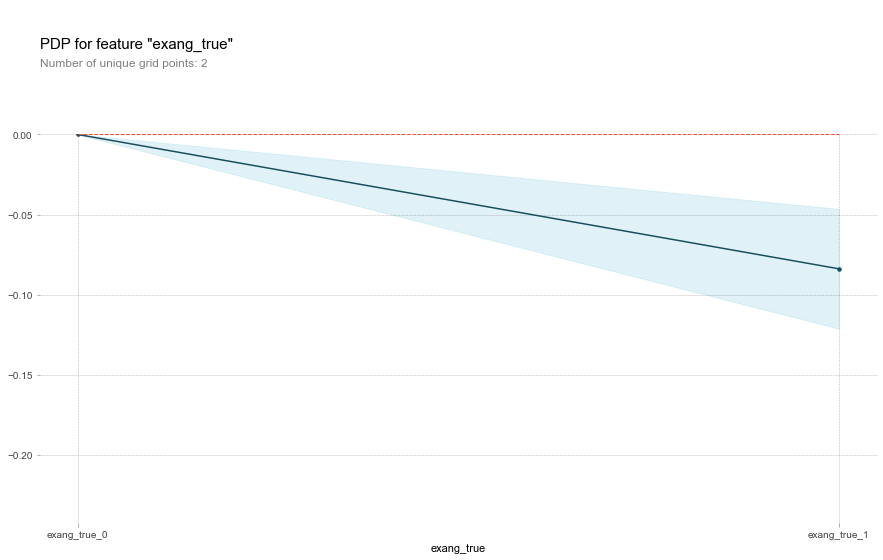

In [33]:
feat_name = 'exang_true'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

有运动引起心绞痛症状，得心脏病概率越低，这个和常识有点儿相悖

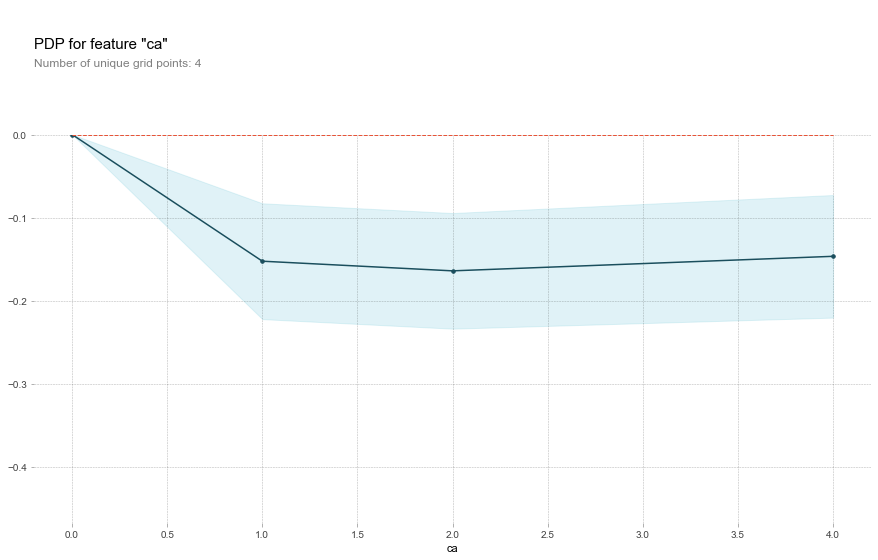

In [34]:
feat_name = 'ca'
pdp_dist = pdp.pdp_isolate(model = model, dataset = X_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

主血管数量越高，得心脏病概率越低，这个和常识相符

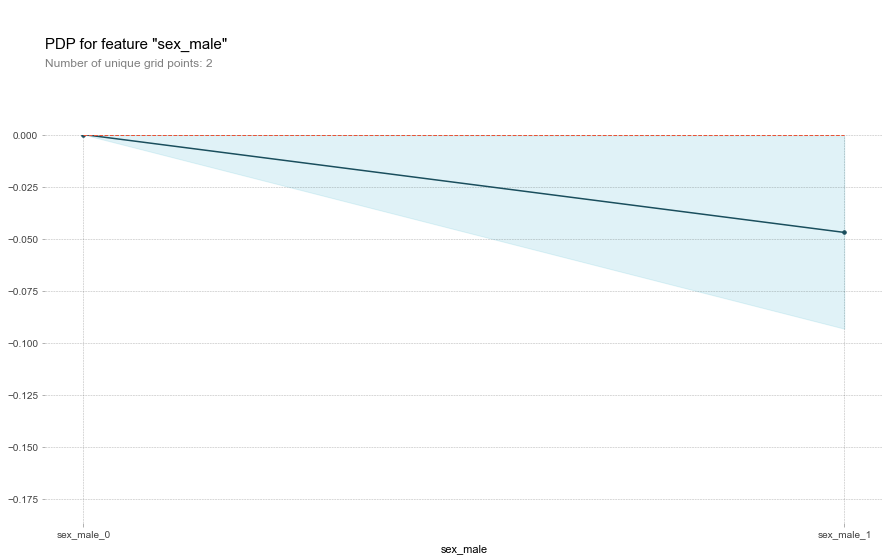

In [35]:
feat_name = 'sex_male'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

男性得心脏病概率较低

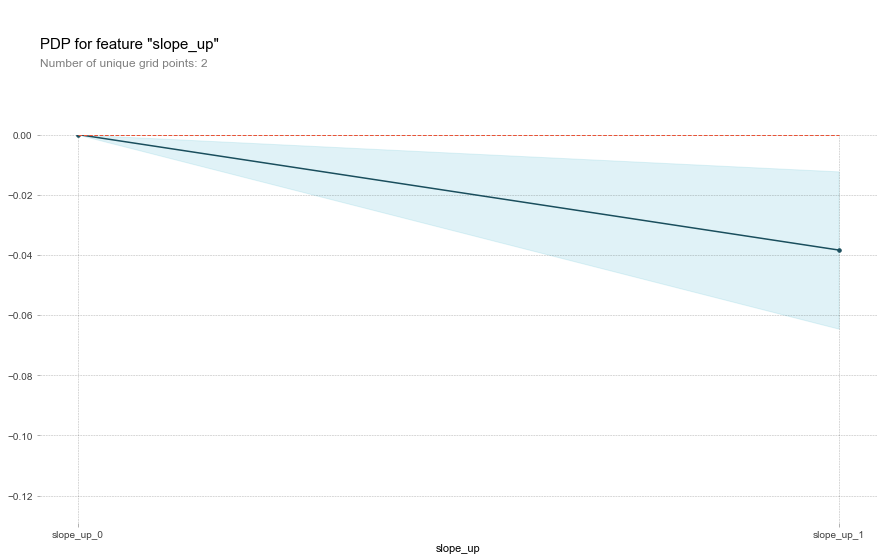

In [36]:
feat_name = 'slope_up'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

有ST段斜率特征，得心脏病概率越低。

In [37]:
plt.rcParams['font.sans-serif'] = ['SimHei']

#plt.rcParams['axes.unicode_minus'] = False

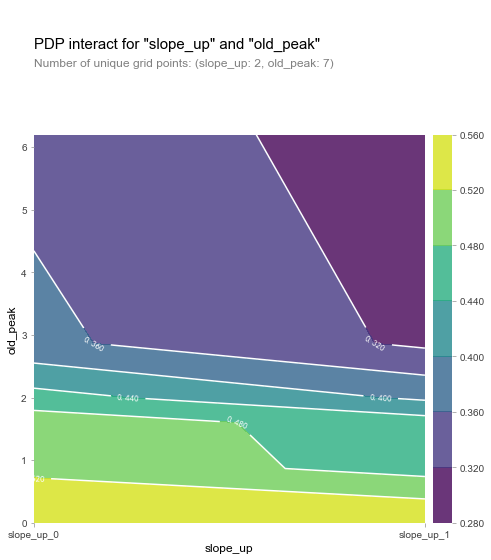

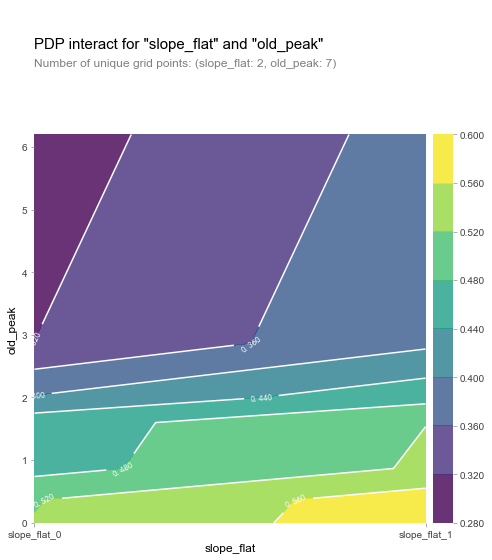

In [38]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['slope_up', 'oldpeak'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['slope_up', 'old_peak'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['slope_flat', 'oldpeak'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['slope_flat', 'old_peak'], plot_type='contour')
plt.show()

运动引起ST段压低，越低，得心脏病概率越高
斜率越平缓，运动引起ST段压低，得心脏病概率越高
有待确认

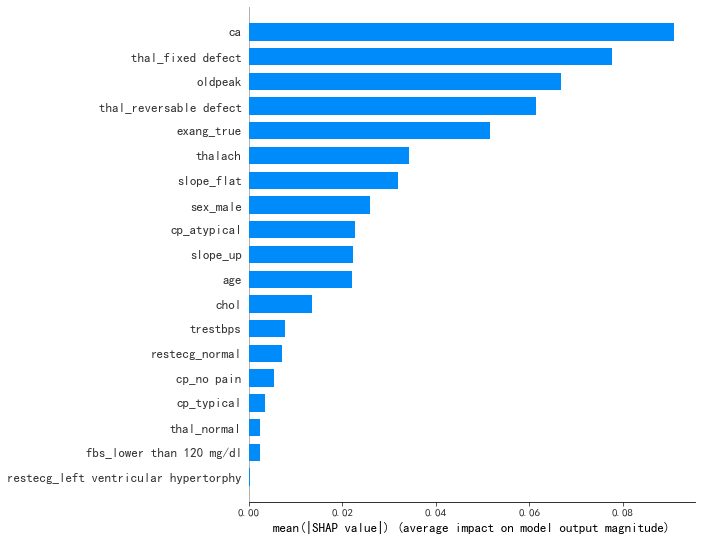

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

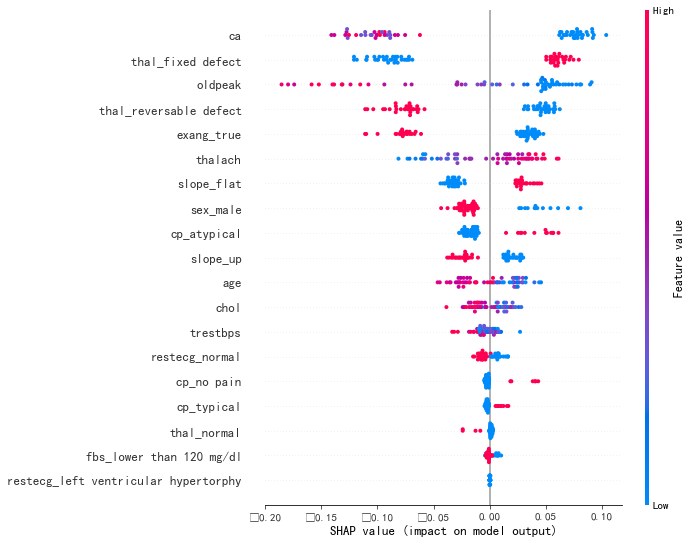

In [41]:
shap.summary_plot(shap_values[1], X_test)

大血管数量越低，得心脏病概率越高

In [43]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [44]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [45]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

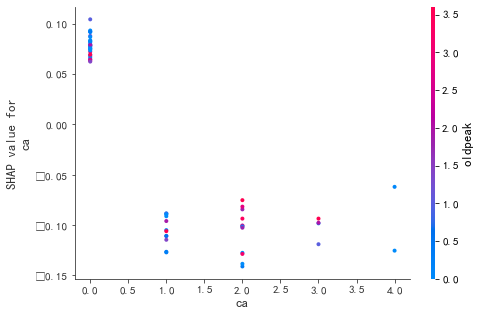

In [46]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('ca', shap_values[1], X_test, interaction_index="oldpeak")

主血管数目越低，运动导致ST段压低越小，得心脏病概率越高。

In [47]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])